In [1]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg
from utils import sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 

from __future__ import print_function
import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [2]:
class PLN_full():
    def __init__(self, C_init, beta_init, M_init, S_init, requires_tridiag = True): 
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  the entries should be int but dtype = float. 
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'C_init' : initialization for C. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
            'requires_tridiag' : bool. If True, the parameters C wil be a vector 
                                of size (n(n+1)/2). It will form a lower tridiagonal matrix after,
                                but we encode it as a vector for pytorch. Advantages : we get about half less 
                                parameter if True. 
                                If False, C will be a Matrix of size (n,n). It won't be a lower tridiagonal Matrix
                                after some gradient steps. 
        '''
        # model parameters
        
        # we start with the initialization of C, that is the most subtle. If you want tridiagonals matrices 
        # at every iteration then the parameters C of the optimizer will be a vector ( we will change this vector 
        # into a matrix at each iteration to compute the loss. It is more convenient this way. 
        #Else, it will be a matrix

        
        if requires_tridiag : 
            self.C = torch.clone(mat2vec_lower_tridiag(C_init))
            self.requires_tridiag = True 
        else : 
            self.C = torch.clone(C_init) 
            self.requires_tridiag = False 
            
        self.C.requires_grad_(True)
        self.Sigma = torch.clone(torch.mm(C_init,C_init.T))
        self.Sigma.requires_grad_(False) # we don't need to have a gradient for Sigma since we will 
                                         # always update it with a closed form (since we have constraints
                                         # of positivity and symmetry)
        #note that C and sigma have a similr role here. We will use either C or Sigma 
        #depending on the loss we choose. 
        
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        
        
        self.params = {'S' : self.S,'M' : self.M,'C' : self.C, 'beta' : self.beta, 'Sigma' : self.Sigma}
        
        self.old_loss = 1
        
        # some list to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
        self.n, self.p = self.Y.shape
        
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only choose update beta and sigma once. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max,
                            requires_closed_Sigma= True, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        
        self.optimizer = torch.optim.Adam([self.S,self.M,self.C], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        # choose the right loss. Note that the loss uses C here. 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : 
            gain = self.compute_ELBO
            
        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, gain ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= False, verbose = verbose)
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            
    
            
            
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  requires_closed_Sigma, verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we wil 
                                all compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'requires_closed_Sigma' : bool. tells if we are using Sigma (True) or C(False). 
                                          Here just to keep track of the error.
                                          between self.Sigma and true_Sigma

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #print('sanity check : ', torch.norm(params['C'].grad+grad_C(data[0], data[1],data[2] ,params['M'] ,params['S'] ,params['C'] ,params['beta']) ))
            if torch.isnan(loss).item() == True : 
                print('NAN')
            optimizer.step()
            #scheduler.step(loss.item())
            
            
            delta = self.old_loss - loss.item() 
            '''
            if delta < 0 : 
                print('We regressed of ', delta )
            else : 
                print('We gain ', delta )
            '''
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            if requires_closed_Sigma : # if we use Sigma as parameter 
                self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            else : #if we use C 
                if len(params['C'].shape) > 1 : # C is a matrix ( requires_tridiag = False)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(self.C,self.C.T)-true_Sigma)**2).item())
                else : # C is a vector (requires_tridiag = true)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(vec2mat_lower_tridiag(self.C),
                                                           vec2mat_lower_tridiag(self.C).T)-true_Sigma)**2).item())

            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%100 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                #print_stats(loss, params, optimizer)
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
            #print_stats(loss, params, optimizer)  
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
            
    def full_grad_ascent_PCA : 
        pass 


In [3]:
def print_stats(loss, params, optimizer): 
    '''
    small function that print some stats. 

    It will print the actual learning rate of the optimizer, the actual log likelihood 
    and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
    when we are close to the optimum. 
    '''
    print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
    print('---------------------------------log likelihood :', - loss.item())
    for param_name, param in params.items(): 
        try :
            with torch.no_grad : # to avoid Warnings 
                print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
        except : 
            pass 





def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 
def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T
def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad


def closed_Sigma(M,S,covariates,beta):
    n = M.shape[0]
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/n*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)


def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''
    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C n argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)

def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is Sigma. 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

#some sanity checks to see if we have the right closed forms. Those quantities should be zero. 
#print(grad_Sigma(Y_sampled, O, covariates, M_init,S_init, closed_Sigma(M_init,S_init, covariates,beta_init), beta_init))
#print(grad_beta(Y_sampled, O, covariates, M_init,S_init, C_init, closed_beta(covariates,M_init)))


In [4]:
def vec2mat_lower_tridiag(vectC): 
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n))#, dtype = torch.float)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.8**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.8**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))



def grad_test(Y_, O_, covariates_,M_ ,S_ ,C_ ,beta_): 
    '''
    small function to try ma gradients. 
    '''
    Y = torch.clone(Y_)
    O = torch.clone(O_)
    covariates = torch.clone(covariates_)
    M = torch.clone(M_)
    S = torch.clone(S_)
    C = torch.clone(C_)
    beta = torch.clone(beta_)
    for i in range(500): 
        grad = grad_C(Y, O, covariates ,M ,S ,C ,beta)
        C+=0.00000015*grad 
        if torch.isnan(ELBO(Y, O, covariates ,M ,S ,C ,beta)) == True : 
            print('nan')
        if i % 200 == 0: 
            print('ELBO : ', ELBO(Y, O, covariates ,M ,S ,C ,beta))
        #print('norm grad : ', torch.norm(grad))


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

# Data generation

In [5]:
d = 4 # nb of cavariates
n = 5000; p = 300

## Generate the true parameters

In [6]:
true_Sigma = torch.from_numpy(toeplitz(0.5**np.arange(p)))
#true_Sigma = build_block_Sigma(p,10)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled = torch.from_numpy(sample_model.sample(true_Sigma,true_beta, O, covariates)) 

data = [Y_sampled.double(), O, covariates]

## Generate some Data according to the true parameters

In [7]:
torch.manual_seed(0)

noise = torch.randn(p) 
Sigma_init =  torch.diag(noise**2)
#Sigma_init = torch.from_numpy(toeplitz(0.4**np.arange(p)))
C_init = torch.cholesky(Sigma_init)
beta_init = torch.rand((d, p))

M_init = torch.ones((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.ones((n,p))/8 # some random values to initializ. we divise to avoid nan values 

## Comparison of models

### We use threadings to go faster.  Allows to lauch all the models at the same time. 

In [8]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init) # we do not care of requires_tridiag since we use Sigma 
model_VEM_both = PLN_full(C_init, beta_init, M_init, S_init)
model_full = PLN_full(C_init, beta_init, M_init, S_init)

t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
          args = [data, 1000           ,20              , 0.01     , 0.1             , True] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
          args = [data, 1000           ,20              , 0.01     , 0.1             , False] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
          args = [data, 1000           ,20              , 0.01     , 0.1             , False] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_full = threading.Thread(target =model_full.full_grad_ascent,
          args = [data, 10000           , 0.03     , False] )
                 #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 
    
    
    #self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True )
t0 = time.time()

t_beta.start()
t_Sigma.start()
t_both.start()
t_full.start()

t_beta.join()
t_Sigma.join()
t_both.join()
t_full.join()

print('Execution time : ', time.time()-t0)

dict_models = {'closed_beta' : model_VEM_beta,'closed_Sigma' : model_VEM_Sigma, 
          'both_closed' :model_VEM_both, 'full' : model_full}

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01041
 MSE with beta :  1.22612
ELBO :  -312848244.33402
Delta :  -312848243.3340191
---------------------------------Maximum number of iterations reached :  20 last delta =  195898.19212547317
 MSE with Sigma :  0.63768
 MSE with beta :  1.22612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.67036
 MSE with beta :  0.87548
ELBO :  18826817.44159
Delta :  312635.8305260055
---------------------------------Maximum number of iterations reached :  20 last delta =  160937.74267825112
 MSE with Sigma :  1.00267
 MSE with beta :  0.87548
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.00971
 MSE with beta :  0.78283
ELBO :  22191885.44538
Delta :  174937.7677600421
---------------------------------Maximum number of iterations reached :  20 last delta =  153493.09427895024
 MSE with Sigma :  1.07064
 MSE with beta :  0.78283
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.07177
 MSE wi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.00784
 MSE with beta :  0.06264
ELBO :  65618192.73595
Delta :  21043.779943697155
---------------------------------Maximum number of iterations reached :  20 last delta =  17951.790227495134
 MSE with Sigma :  1.00497
 MSE with beta :  0.06264
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.00483
 MSE with beta :  0.05931
ELBO :  66002217.32288
Delta :  18087.459374390543
---------------------------------Maximum number of iterations reached :  20 last delta =  15337.734326265752
 MSE with Sigma :  1.00201
 MSE with beta :  0.05931
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.00186
 MSE with beta :  0.05628
ELBO :  66331204.63885
Delta :  15455.135868482292
---------------------------------Maximum number of iterations reached :  20 last delta =  13023.657805755734
 MSE with Sigma :  0.99909
 MSE with beta :  0.05628
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.99895
 MSE wi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.93308
 MSE with beta :  0.02323
ELBO :  67957529.29456
Delta :  273.3486181348562
---------------------------------Maximum number of iterations reached :  20 last delta =  232.86517541110516
 MSE with Sigma :  0.93052
 MSE with beta :  0.02323
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.93038
 MSE with beta :  0.02265
ELBO :  67962339.13266
Delta :  260.38661727309227
---------------------------------Maximum number of iterations reached :  20 last delta =  222.88569775223732
 MSE with Sigma :  0.92782
 MSE with beta :  0.02265
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.92769
 MSE with beta :  0.0221
ELBO :  67966935.89426
Delta :  248.826236769557
---------------------------------Maximum number of iterations reached :  20 last delta =  213.87366169691086
 MSE with Sigma :  0.92513
 MSE with beta :  0.0221
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.92499
 MSE with be

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.86354
 MSE with beta :  0.01368
ELBO :  68042367.58129
Delta :  108.53136748075485
---------------------------------Maximum number of iterations reached :  20 last delta =  98.62242841720581
 MSE with Sigma :  0.86131
 MSE with beta :  0.01368
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.8612
 MSE with beta :  0.01348
ELBO :  68044377.21288
Delta :  105.60433089733124
---------------------------------Maximum number of iterations reached :  20 last delta =  96.04335299134254
 MSE with Sigma :  0.85899
 MSE with beta :  0.01348
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.85888
 MSE with beta :  0.01328
ELBO :  68046334.46188
Delta :  102.76064637303352
---------------------------------Maximum number of iterations reached :  20 last delta =  93.60461284220219
 MSE with Sigma :  0.8567
 MSE with beta :  0.01328
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.85658
 MSE with be

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.80784
 MSE with beta :  0.0098
ELBO :  68082190.85071
Delta :  54.57760567963123
---------------------------------Maximum number of iterations reached :  20 last delta =  50.82612857222557
 MSE with Sigma :  0.80609
 MSE with beta :  0.0098
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.806
 MSE with beta :  0.0097
ELBO :  68083222.59428
Delta :  53.290413454174995
---------------------------------Maximum number of iterations reached :  20 last delta =  49.65203648805618
 MSE with Sigma :  0.80427
 MSE with beta :  0.0097
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.80418
 MSE with beta :  0.00961
ELBO :  68084230.40195
Delta :  51.99085469543934
---------------------------------Maximum number of iterations reached :  20 last delta =  48.507455080747604
 MSE with Sigma :  0.80245
 MSE with beta :  0.00961
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.80236
 MSE with beta : 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.75712
 MSE with beta :  0.00784
ELBO :  68103224.42922
Delta :  29.399833098053932
---------------------------------Maximum number of iterations reached :  20 last delta =  27.756274715065956
 MSE with Sigma :  0.75512
 MSE with beta :  0.00784
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.75501
 MSE with beta :  0.00779
ELBO :  68103786.95887
Delta :  28.801537796854973
---------------------------------Maximum number of iterations reached :  20 last delta =  27.17158144712448
 MSE with Sigma :  0.75298
 MSE with beta :  0.00779
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.75287
 MSE with beta :  0.00774
ELBO :  68104337.51435
Delta :  28.108562171459198
---------------------------------Maximum number of iterations reached :  20 last delta =  26.576922923326492
 MSE with Sigma :  0.7508
 MSE with beta :  0.00774
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.75069
 MSE with

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6851
 MSE with beta :  0.00674
ELBO :  68114975.35141
Delta :  16.823114454746246
---------------------------------Maximum number of iterations reached :  20 last delta =  16.0781432390213
 MSE with Sigma :  0.68187
 MSE with beta :  0.00674
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6817
 MSE with beta :  0.00671
ELBO :  68115300.74009
Delta :  16.491459473967552
---------------------------------Maximum number of iterations reached :  20 last delta =  15.777865275740623
 MSE with Sigma :  0.6784
 MSE with beta :  0.00671
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.67823
 MSE with beta :  0.00668
ELBO :  68115620.12429
Delta :  16.181755751371384
---------------------------------Maximum number of iterations reached :  20 last delta =  15.481413662433624
 MSE with Sigma :  0.67488
 MSE with beta :  0.00668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6747
 MSE with bet

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.57239
 MSE with beta :  0.00606
ELBO :  68121991.62619
Delta :  10.427261099219322
---------------------------------Maximum number of iterations reached :  20 last delta =  10.047469094395638
 MSE with Sigma :  0.5677
 MSE with beta :  0.00606
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.56745
 MSE with beta :  0.00604
ELBO :  68122194.26684
Delta :  10.267218679189682
---------------------------------Maximum number of iterations reached :  20 last delta =  9.876692831516266
 MSE with Sigma :  0.56272
 MSE with beta :  0.00604
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.56247
 MSE with beta :  0.00602
ELBO :  68122393.65533
Delta :  10.10077702999115
---------------------------------Maximum number of iterations reached :  20 last delta =  9.720881447196007
 MSE with Sigma :  0.5577
 MSE with beta :  0.00602
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.55745
 MSE with be

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.42803
 MSE with beta :  0.00558
ELBO :  68126500.88842
Delta :  6.921043232083321
---------------------------------Maximum number of iterations reached :  20 last delta =  6.715178847312927
 MSE with Sigma :  0.42274
 MSE with beta :  0.00558
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.42247
 MSE with beta :  0.00557
ELBO :  68126635.8937
Delta :  6.850662499666214
---------------------------------Maximum number of iterations reached :  20 last delta =  6.608631908893585
 MSE with Sigma :  0.41718
 MSE with beta :  0.00557
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.4169
 MSE with beta :  0.00555
ELBO :  68126769.08489
Delta :  6.730415776371956
---------------------------------Maximum number of iterations reached :  20 last delta =  6.470886722207069
 MSE with Sigma :  0.41162
 MSE with beta :  0.00555
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.41134
 MSE with beta 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.28331
 MSE with beta :  0.00522
ELBO :  68129586.83197
Delta :  4.917517393827438
---------------------------------Maximum number of iterations reached :  20 last delta =  4.765404179692268
 MSE with Sigma :  0.2786
 MSE with beta :  0.00522
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.27836
 MSE with beta :  0.00521
ELBO :  68129682.65379
Delta :  4.909342244267464
---------------------------------Maximum number of iterations reached :  20 last delta =  4.712418958544731
 MSE with Sigma :  0.27369
 MSE with beta :  0.00521
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.27344
 MSE with beta :  0.0052
ELBO :  68129777.3755
Delta :  4.795998722314835
---------------------------------Maximum number of iterations reached :  20 last delta =  4.648761719465256
 MSE with Sigma :  0.26882
 MSE with beta :  0.0052
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.26858
 MSE with beta : 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.16583
 MSE with beta :  0.00493
ELBO :  68131868.72636
Delta :  3.8703846782445908
---------------------------------Maximum number of iterations reached :  20 last delta =  3.7237961143255234
 MSE with Sigma :  0.16236
 MSE with beta :  0.00493
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.16218
 MSE with beta :  0.00492
ELBO :  68131943.55518
Delta :  3.8217535465955734
---------------------------------Maximum number of iterations reached :  20 last delta =  3.693771541118622
 MSE with Sigma :  0.15877
 MSE with beta :  0.00492
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.15859
 MSE with beta :  0.00491
ELBO :  68132017.95293
Delta :  3.8211193829774857
---------------------------------Maximum number of iterations reached :  20 last delta =  3.708154186606407
 MSE with Sigma :  0.15522
 MSE with beta :  0.00491
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.15504
 MSE with

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0857
 MSE with beta :  0.0047
ELBO :  68133732.96446
Delta :  3.2547490149736404
---------------------------------Maximum number of iterations reached :  20 last delta =  3.1919493228197098
 MSE with Sigma :  0.08356
 MSE with beta :  0.0047
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08345
 MSE with beta :  0.00469
ELBO :  68133796.85349
Delta :  3.262298360466957
---------------------------------Maximum number of iterations reached :  20 last delta =  3.1449450701475143
 MSE with Sigma :  0.08135
 MSE with beta :  0.00469
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08124
 MSE with beta :  0.00468
ELBO :  68133860.48815
Delta :  3.2243680357933044
---------------------------------Maximum number of iterations reached :  20 last delta =  3.1548125445842743
 MSE with Sigma :  0.0792
 MSE with beta :  0.00468
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07909
 MSE with be

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04074
 MSE with beta :  0.00451
ELBO :  68135357.33302
Delta :  2.8725694566965103
---------------------------------Maximum number of iterations reached :  20 last delta =  2.779300317168236
 MSE with Sigma :  0.03969
 MSE with beta :  0.00451
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03964
 MSE with beta :  0.0045
ELBO :  68135413.5501
Delta :  2.886078640818596
---------------------------------Maximum number of iterations reached :  20 last delta =  2.7791715413331985
 MSE with Sigma :  0.03862
 MSE with beta :  0.0045
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03857
 MSE with beta :  0.00449
ELBO :  68135469.6878
Delta :  2.9026944786310196
---------------------------------Maximum number of iterations reached :  20 last delta =  2.760508567094803
 MSE with Sigma :  0.03758
 MSE with beta :  0.00449
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03753
 MSE with beta

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02079
 MSE with beta :  0.00435
ELBO :  68136780.37879
Delta :  2.5088101029396057
---------------------------------Maximum number of iterations reached :  20 last delta =  2.416799709200859
 MSE with Sigma :  0.02039
 MSE with beta :  0.00435
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02036
 MSE with beta :  0.00435
ELBO :  68136829.05704
Delta :  2.4919779747724533
---------------------------------Maximum number of iterations reached :  20 last delta =  2.386323794722557
 MSE with Sigma :  0.01997
 MSE with beta :  0.00435
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01995
 MSE with beta :  0.00435
ELBO :  68136877.40693
Delta :  2.462666228413582
---------------------------------Maximum number of iterations reached :  20 last delta =  2.4069748669862747
 MSE with Sigma :  0.01957
 MSE with beta :  0.00435
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01955
 MSE with 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01351
 MSE with beta :  0.00424
ELBO :  68137964.46648
Delta :  1.9734850972890854
---------------------------------Maximum number of iterations reached :  20 last delta =  1.8022352904081345
 MSE with Sigma :  0.01338
 MSE with beta :  0.00424
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01337
 MSE with beta :  0.00423
ELBO :  68138002.07225
Delta :  1.8951884359121323
---------------------------------Maximum number of iterations reached :  20 last delta =  1.876910150051117
 MSE with Sigma :  0.01324
 MSE with beta :  0.00423
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01323
 MSE with beta :  0.00423
ELBO :  68138040.21213
Delta :  1.9346461296081543
---------------------------------Maximum number of iterations reached :  20 last delta =  1.810779333114624
 MSE with Sigma :  0.0131
 MSE with beta :  0.00423
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0131
 MSE with b

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01108
 MSE with beta :  0.00415
ELBO :  68138834.52373
Delta :  1.2635174989700317
---------------------------------Maximum number of iterations reached :  20 last delta =  1.289419800043106
 MSE with Sigma :  0.01103
 MSE with beta :  0.00415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01103
 MSE with beta :  0.00415
ELBO :  68138861.36758
Delta :  1.3531031757593155
---------------------------------Maximum number of iterations reached :  20 last delta =  1.3643350899219513
 MSE with Sigma :  0.01098
 MSE with beta :  0.00415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01098
 MSE with beta :  0.00415
ELBO :  68138887.6572
Delta :  1.4045297056436539
---------------------------------Maximum number of iterations reached :  20 last delta =  1.230473354458809
 MSE with Sigma :  0.01093
 MSE with beta :  0.00415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01093
 MSE with 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01017
 MSE with beta :  0.00409
ELBO :  68139427.02813
Delta :  0.8412781804800034
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7654775679111481
 MSE with Sigma :  0.01015
 MSE with beta :  0.00409
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01015
 MSE with beta :  0.00409
ELBO :  68139443.82262
Delta :  0.9024236798286438
---------------------------------Maximum number of iterations reached :  20 last delta =  0.9277942627668381
 MSE with Sigma :  0.01013
 MSE with beta :  0.00409
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01013
 MSE with beta :  0.00409
ELBO :  68139461.50308
Delta :  1.000102937221527
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7551180869340897
 MSE with Sigma :  0.01011
 MSE with beta :  0.00409
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01011
 MSE wit

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00977
 MSE with beta :  0.00404
ELBO :  68139821.16007
Delta :  0.13209384679794312
---------------------------------Maximum number of iterations reached :  20 last delta =  0.9402708411216736
 MSE with Sigma :  0.00976
 MSE with beta :  0.00404
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00976
 MSE with beta :  0.00404
ELBO :  68139832.64793
Delta :  0.8409331887960434
---------------------------------Maximum number of iterations reached :  20 last delta =  0.6610881984233856
 MSE with Sigma :  0.00975
 MSE with beta :  0.00404
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00975
 MSE with beta :  0.00404
ELBO :  68139845.33249
Delta :  0.48684343695640564
---------------------------------Maximum number of iterations reached :  20 last delta =  0.5893142372369766
 MSE with Sigma :  0.00974
 MSE with beta :  0.00404
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00974
 MSE 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00957
 MSE with beta :  0.00401
ELBO :  68140068.41299
Delta :  -0.25270645320415497
---------------------------------Maximum number of iterations reached :  20 last delta =  0.4436507374048233
 MSE with Sigma :  0.00957
 MSE with beta :  0.00401
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00957
 MSE with beta :  0.00401
ELBO :  68140078.68426
Delta :  0.5743790715932846
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.1442723274230957
 MSE with Sigma :  0.00956
 MSE with beta :  0.00401
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00956
 MSE with beta :  0.00401
ELBO :  68140080.92217
Delta :  -0.44708122313022614
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.12355272471904755
 MSE with Sigma :  0.00956
 MSE with beta :  0.00401
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00955


iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
ELBO :  68140211.40002
Delta :  0.1286911815404892
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.41756200790405273
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
ELBO :  68140213.93046
Delta :  0.016551509499549866
---------------------------------Maximum number of iterations reached :  20 last delta =  0.2962147146463394
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
ELBO :  68140221.1787
Delta :  0.49000850319862366
---------------------------------Maximum number of iterations reached :  20 last delta =  0.4702090173959732
 MSE with Sigma :  0.00946
 MSE with beta :  0.00399
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00946
 MS

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00941
 MSE with beta :  0.00398
ELBO :  68140272.42702
Delta :  0.3628283739089966
---------------------------------Maximum number of iterations reached :  20 last delta =  0.8993606269359589
 MSE with Sigma :  0.00941
 MSE with beta :  0.00398
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00941
 MSE with beta :  0.00398
ELBO :  68140269.97888
Delta :  0.04442134499549866
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7993890196084976
 MSE with Sigma :  0.0094
 MSE with beta :  0.00398
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0094
 MSE with beta :  0.00398
ELBO :  68140275.51799
Delta :  -0.8185926824808121
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.4320111572742462
 MSE with Sigma :  0.0094
 MSE with beta :  0.00398
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0094
 MSE wit

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
ELBO :  68140291.07186
Delta :  0.750616654753685
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.15054157376289368
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
ELBO :  68140291.31382
Delta :  -0.6931623667478561
---------------------------------Maximum number of iterations reached :  20 last delta =  0.027466028928756714
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
ELBO :  68140286.4637
Delta :  -0.6429129540920258
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.43439069390296936
 MSE with Sigma :  0.00938
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00938
 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140282.45683
Delta :  -0.470188245177269
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1520182341337204
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140289.08151
Delta :  1.1421121209859848
---------------------------------Maximum number of iterations reached :  20 last delta =  0.9740852415561676
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140288.12864
Delta :  0.8990239053964615
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.21374347805976868
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140277.23254
Delta :  -0.8132710307836533
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.37285806238651276
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140275.35591
Delta :  -0.713748961687088
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.9246274530887604
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
ELBO :  68140277.46165
Delta :  0.5249026566743851
---------------------------------Maximum number of iterations reached :  20 last delta =  -1.7563385963439941
 MSE with Sigma :  0.00937
 MSE with beta :  0.00397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 M

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140267.51545
Delta :  -2.2392455637454987
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01072847843170166
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140265.13504
Delta :  2.066618725657463
---------------------------------Maximum number of iterations reached :  20 last delta =  0.93900266289711
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140269.58402
Delta :  0.7507796734571457
---------------------------------Maximum number of iterations reached :  20 last delta =  0.4148503392934799
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE wit

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140256.04074
Delta :  -1.3411818593740463
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.43594956398010254
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140266.46112
Delta :  0.743219181895256
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.42834851145744324
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140265.91553
Delta :  0.8224753737449646
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.573177695274353
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MS

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140249.55773
Delta :  0.7808134704828262
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.29926636815071106
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140248.17934
Delta :  -0.5715004056692123
---------------------------------Maximum number of iterations reached :  20 last delta =  1.5093270540237427
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140253.47487
Delta :  0.6255041062831879
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.23621952533721924
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 M

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140244.76878
Delta :  -0.3383132219314575
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.21925868093967438
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140249.13322
Delta :  0.6077014654874802
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7364194542169571
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140242.94841
Delta :  0.050957709550857544
---------------------------------Maximum number of iterations reached :  20 last delta =  0.23222266137599945
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 

---------------------------------Maximum number of iterations reached :  20 last delta =  1.3129124641418457
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140244.17986
Delta :  -0.054845958948135376
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1828891485929489
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140242.81663
Delta :  1.4596396535634995
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.7755724638700485
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140239.93007
Delta :  0.9978118687868118
---------------------------------Maximum number of iterations reached : 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140239.81137
Delta :  -0.11664091050624847
---------------------------------Maximum number of iterations reached :  20 last delta =  0.8244349360466003
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140237.15286
Delta :  1.2631621807813644
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.12455461919307709
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140237.09631
Delta :  -0.3966536968946457
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.13319596648216248
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937


---------------------------------Maximum number of iterations reached :  20 last delta =  2.3301664292812347
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140237.88222
Delta :  2.5698417276144028
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.05085526406764984
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140240.11983
Delta :  -0.06503143906593323
---------------------------------Maximum number of iterations reached :  20 last delta =  0.6586671769618988
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140235.69224
Delta :  0.34070636332035065
---------------------------------Maximum number of iterations reached :

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140228.02131
Delta :  0.45135556161403656
---------------------------------Maximum number of iterations reached :  20 last delta =  0.024443551898002625
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140236.7673
Delta :  0.8277570307254791
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7024106830358505
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140230.16874
Delta :  -0.1890396624803543
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7392958551645279
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140235.97656
Delta :  0.13820582628250122
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.7731400728225708
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140225.77784
Delta :  -0.16832780838012695
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.6456199139356613
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140230.68309
Delta :  0.08526308834552765
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.31038643419742584
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140230.5784
Delta :  -0.816114068031311
---------------------------------Maximum number of iterations reached :  20 last delta =  1.736041784286499
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140231.45939
Delta :  2.0605831891298294
---------------------------------Maximum number of iterations reached :  20 last delta =  1.1158149987459183
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140227.51738
Delta :  -0.09424315392971039
---------------------------------Maximum number of iterations reached :  20 last delta =  0.17679081857204437
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE w

---------------------------------Maximum number of iterations reached :  20 last delta =  1.4384823590517044
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140233.45284
Delta :  -0.23989853262901306
---------------------------------Maximum number of iterations reached :  20 last delta =  -2.733595550060272
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140227.13293
Delta :  -3.0375630110502243
---------------------------------Maximum number of iterations reached :  20 last delta =  0.9705067425966263
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140229.60103
Delta :  0.39496272802352905
---------------------------------Maximum number of iterations reached : 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140221.20094
Delta :  -0.34637877345085144
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1326034963130951
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140224.74516
Delta :  0.10474838316440582
---------------------------------Maximum number of iterations reached :  20 last delta =  0.9371052235364914
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140225.1554
Delta :  0.8221307396888733
---------------------------------Maximum number of iterations reached :  20 last delta =  -1.7235939055681229
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE

---------------------------------Maximum number of iterations reached :  20 last delta =  0.4124753773212433
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140228.05003
Delta :  0.7636556327342987
---------------------------------Maximum number of iterations reached :  20 last delta =  1.3660622239112854
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140226.94985
Delta :  -0.3743492364883423
---------------------------------Maximum number of iterations reached :  20 last delta =  -2.1280646473169327
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140217.7387
Delta :  -1.3486891090869904
---------------------------------Maximum number of iterations reached :  2

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140224.66284
Delta :  0.912568211555481
---------------------------------Maximum number of iterations reached :  20 last delta =  0.6278136223554611
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140224.30715
Delta :  -0.015553474426269531
---------------------------------Maximum number of iterations reached :  20 last delta =  1.7030532211065292
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
ELBO :  68140231.14566
Delta :  0.44139184057712555
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.658646747469902
 MSE with Sigma :  0.00937
 MSE with beta :  0.00396
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00937
 MSE

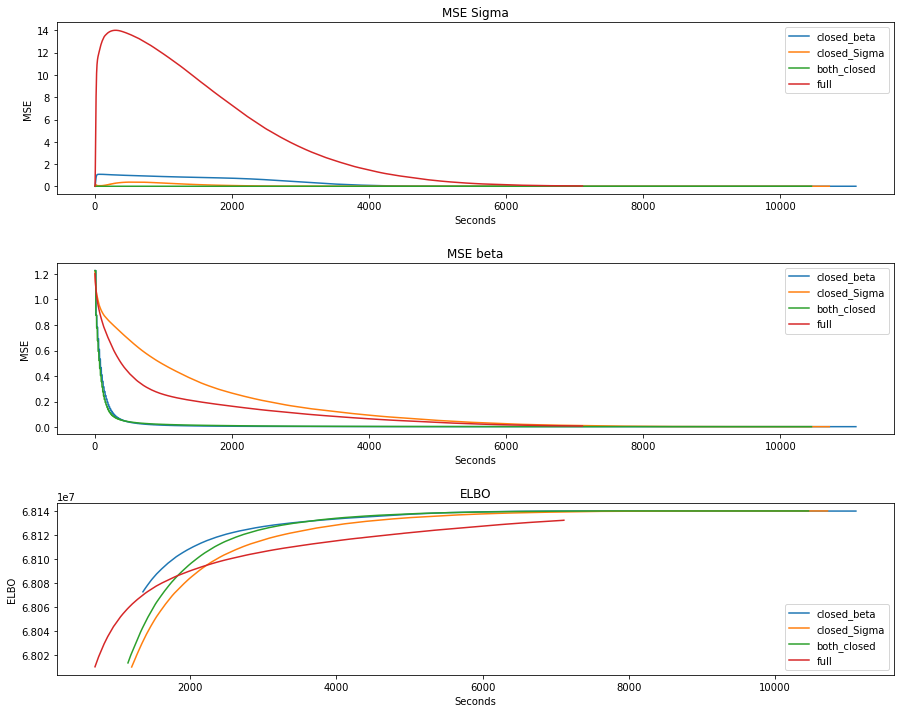

In [11]:
def compare_models(dict_models):
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    n,p = dict_models['full'].Y.shape
    name_dossier = 'n = '+str(n)+', p = ' +str(p)
    scaler = dict_models['full'].ELBO_list[-1]
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        #ax[0].set_ybound( lower=0, upper=0.7)
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        length = len(abscisse)
        
        ax[2].plot(abscisse[-int(length*90/100):], model.ELBO_list[-int(length*90/100):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    plt.savefig('n = 5000, p = 300,noscaling')
    plt.show()
    
compare_models(dict_models)
    

    

### VEM were we use only the closed form for  $\beta$ 

In [85]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07371
 MSE with beta :  1.4837
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
---------------------------------Maximum number of iterations reached :  20 last delta =  863.2960397875577
 MSE with Sigma :  0.0645
 MSE with beta :  1.4837
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.06434
 MSE with beta :  1.11726
ELBO :  71151.49957
Delta :  2381.5096649338375
---------------------------------Maximum number of iterations reached :  20 last delta =  682.8450955784065
 MSE with Sigma :  0.05855
 MSE with beta :  1.11726
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05811
 MSE with beta :  0.99896
ELBO :  85402.51193
Delta :  723.9903459600464
---------------------------------Maximum number of iterations reached :  20 last delta =  644.7985473015142
 MSE with Sigma :  0.04961
 MSE with beta :  0.99896
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0492
 MSE with beta :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  38.409292345284484
 MSE with Sigma :  0.08285
 MSE with beta :  0.19797
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08298
 MSE with beta :  0.19539
ELBO :  259795.81029
Delta :  39.43593269173289
---------------------------------Maximum number of iterations reached :  20 last delta =  31.063452069618506
 MSE with Sigma :  0.08531
 MSE with beta :  0.19539
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08543
 MSE with beta :  0.19301
ELBO :  260480.59935
Delta :  32.034664054226596
---------------------------------Maximum number of iterations reached :  20 last delta =  24.71330026551732
 MSE with Sigma :  0.0875
 MSE with beta :  0.19301
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0876
 MSE with beta :  0.1908
ELBO :  261029.81145
Delta :  25.63783037138637
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.27750904933782294
 MSE with Sigma :  0.0846
 MSE with beta :  0.16261
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08457
 MSE with beta :  0.16208
ELBO :  262826.34322
Delta :  0.5471114290412515
---------------------------------Maximum number of iterations reached :  20 last delta =  0.27007458539446816
 MSE with Sigma :  0.08404
 MSE with beta :  0.16208
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08401
 MSE with beta :  0.16157
ELBO :  262832.34355
Delta :  0.5246775823761709
---------------------------------Maximum number of iterations reached :  20 last delta =  0.26244589022826403
 MSE with Sigma :  0.08351
 MSE with beta :  0.16157
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08348
 MSE with beta :  0.16106
ELBO :  262838.16087
Delta :  0.5040122189093381
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.125164489261806
 MSE with Sigma :  0.07869
 MSE with beta :  0.15005
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07869
 MSE with beta :  0.14976
ELBO :  262954.17367
Delta :  0.18899644078919664
---------------------------------Maximum number of iterations reached :  20 last delta =  0.12272696732543409
 MSE with Sigma :  0.07872
 MSE with beta :  0.14976
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07873
 MSE with beta :  0.14947
ELBO :  262956.77445
Delta :  0.18416222091764212
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1197170342784375
 MSE with Sigma :  0.07876
 MSE with beta :  0.14947
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07877
 MSE with beta :  0.14919
ELBO :  262959.32382
Delta :  0.1812295054551214
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.08574453491019085
 MSE with Sigma :  0.08069
 MSE with beta :  0.14262
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0807
 MSE with beta :  0.14244
ELBO :  263020.88865
Delta :  0.10599115944933146
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0800266694277525
 MSE with Sigma :  0.08076
 MSE with beta :  0.14244
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08077
 MSE with beta :  0.14226
ELBO :  263022.58816
Delta :  0.09789918002206832
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08126539969816804
 MSE with Sigma :  0.08084
 MSE with beta :  0.14226
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08084
 MSE with beta :  0.14209
ELBO :  263024.29532
Delta :  0.10166087019024417
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  0.06492419232381508
 MSE with Sigma :  0.08296
 MSE with beta :  0.13778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08296
 MSE with beta :  0.13766
ELBO :  263068.83982
Delta :  0.07328540878370404
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06364068749826401
 MSE with Sigma :  0.08303
 MSE with beta :  0.13766
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08303
 MSE with beta :  0.13753
ELBO :  263070.13789
Delta :  0.07267137663438916
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06326330301817507
 MSE with Sigma :  0.08309
 MSE with beta :  0.13753
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0831
 MSE with beta :  0.13741
ELBO :  263071.42464
Delta :  0.07174995506647974
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.05007888755062595
 MSE with Sigma :  0.08492
 MSE with beta :  0.13423
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08493
 MSE with beta :  0.13413
ELBO :  263105.50996
Delta :  0.05499906209297478
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04953303880756721
 MSE with Sigma :  0.08498
 MSE with beta :  0.13413
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08498
 MSE with beta :  0.13403
ELBO :  263106.50881
Delta :  0.05421104887500405
---------------------------------Maximum number of iterations reached :  20 last delta =  0.048804122023284435
 MSE with Sigma :  0.08503
 MSE with beta :  0.13403
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08503
 MSE with beta :  0.13394
ELBO :  263107.50958
Delta :  0.054735518351662904
---------------------------------Maximum number of iterations reached :  2

---------------------------------Maximum number of iterations reached :  20 last delta =  0.040255964384414256
 MSE with Sigma :  0.08631
 MSE with beta :  0.13165
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08631
 MSE with beta :  0.13157
ELBO :  263131.8754
Delta :  0.04594182374421507
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03982601343886927
 MSE with Sigma :  0.08635
 MSE with beta :  0.13157
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08635
 MSE with beta :  0.13148
ELBO :  263132.69602
Delta :  0.04497332131722942
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03980025026248768
 MSE with Sigma :  0.08639
 MSE with beta :  0.13148
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0864
 MSE with beta :  0.1314
ELBO :  263133.50942
Delta :  0.04479499818990007
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03517306683352217
 MSE with Sigma :  0.08749
 MSE with beta :  0.12919
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08749
 MSE with beta :  0.12913
ELBO :  263156.21947
Delta :  0.04024929599836469
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03195021999999881
 MSE with Sigma :  0.08752
 MSE with beta :  0.12913
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08753
 MSE with beta :  0.12906
ELBO :  263156.87607
Delta :  0.037104164832271636
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03155295527540147
 MSE with Sigma :  0.08755
 MSE with beta :  0.12906
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08756
 MSE with beta :  0.12899
ELBO :  263157.52788
Delta :  0.036869272822514176
---------------------------------Maximum number of iterations reached :  2

---------------------------------Maximum number of iterations reached :  20 last delta =  0.025820151960942894
 MSE with Sigma :  0.08837
 MSE with beta :  0.1273
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08838
 MSE with beta :  0.12724
ELBO :  263174.47592
Delta :  0.030948189494665712
---------------------------------Maximum number of iterations reached :  20 last delta =  0.025074645993299782
 MSE with Sigma :  0.0884
 MSE with beta :  0.12724
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0884
 MSE with beta :  0.12719
ELBO :  263174.99441
Delta :  0.030712872394360602
---------------------------------Maximum number of iterations reached :  20 last delta =  0.025090879993513227
 MSE with Sigma :  0.08843
 MSE with beta :  0.12719
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08843
 MSE with beta :  0.12714
ELBO :  263175.50761
Delta :  0.030312968010548502
---------------------------------Maximum number of iterations reached :  

---------------------------------Maximum number of iterations reached :  20 last delta =  0.01846514007775113
 MSE with Sigma :  0.08923
 MSE with beta :  0.12582
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08923
 MSE with beta :  0.12579
ELBO :  263188.94001
Delta :  0.023410474066622555
---------------------------------Maximum number of iterations reached :  20 last delta =  0.018312330823391676
 MSE with Sigma :  0.08925
 MSE with beta :  0.12579
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08926
 MSE with beta :  0.12575
ELBO :  263189.32382
Delta :  0.02323750057257712
---------------------------------Maximum number of iterations reached :  20 last delta =  0.019221483264118433
 MSE with Sigma :  0.08928
 MSE with beta :  0.12575
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08928
 MSE with beta :  0.12571
ELBO :  263189.70429
Delta :  0.024482256965711713
---------------------------------Maximum number of iterations reached : 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.012399884988553822
 MSE with Sigma :  0.09011
 MSE with beta :  0.12494
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09011
 MSE with beta :  0.12492
ELBO :  263199.03969
Delta :  0.016551844601053745
---------------------------------Maximum number of iterations reached :  20 last delta =  0.013319655845407397
 MSE with Sigma :  0.09014
 MSE with beta :  0.12492
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09014
 MSE with beta :  0.1249
ELBO :  263199.30645
Delta :  0.015765990421641618
---------------------------------Maximum number of iterations reached :  20 last delta =  0.012277660833206028
 MSE with Sigma :  0.09017
 MSE with beta :  0.1249
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09017
 MSE with beta :  0.12488
ELBO :  263199.572
Delta :  0.016871535684913397
---------------------------------Maximum number of iterations reached :  2

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09107
 MSE with beta :  0.12458
ELBO :  263205.84588
Delta :  0.011794279038440436
---------------------------------Maximum number of iterations reached :  20 last delta =  0.007897839008364826
 MSE with Sigma :  0.0911
 MSE with beta :  0.12458
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09111
 MSE with beta :  0.12458
ELBO :  263206.01362
Delta :  0.01092369796242565
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006889139593113214
 MSE with Sigma :  0.09113
 MSE with beta :  0.12458
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09114
 MSE with beta :  0.12458
ELBO :  263206.18342
Delta :  0.010746872576419264
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006383828178513795
 MSE with Sigma :  0.09117
 MSE with beta :  0.12458
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09117
 MS

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0045761665678583086
 MSE with Sigma :  0.09212
 MSE with beta :  0.12469
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09212
 MSE with beta :  0.1247
ELBO :  263210.14936
Delta :  0.006829513527918607
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004037786100525409
 MSE with Sigma :  0.09215
 MSE with beta :  0.1247
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09216
 MSE with beta :  0.12471
ELBO :  263210.24542
Delta :  0.005971107864752412
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0019226670847274363
 MSE with Sigma :  0.09219
 MSE with beta :  0.12471
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09219
 MSE with beta :  0.12472
ELBO :  263210.33305
Delta :  0.0024157147854566574
---------------------------------Maximum number of iterations reached

---------------------------------Maximum number of iterations reached :  20 last delta =  0.003573182679247111
 MSE with Sigma :  0.09318
 MSE with beta :  0.12515
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09316
 MSE with beta :  0.12517
ELBO :  263212.48459
Delta :  0.01173503661993891
---------------------------------Tolerance 0.00022573363431151243 reached in 4 iterations
 MSE with Sigma :  0.09316
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09318
 MSE with beta :  0.12515
ELBO :  263212.49872
Delta :  -0.002106832747813314
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002114314818754792
 MSE with Sigma :  0.09321
 MSE with beta :  0.12515
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0932
 MSE with beta :  0.12518
ELBO :  263212.5558
Delta :  0.0021499597933143377
---------------------------------Maximum number of iterations reached :  20 last delta =  0.

---------------------------------Tolerance 0.0002100840336134454 reached in 16 iterations
 MSE with Sigma :  0.09383
 MSE with beta :  0.12557
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09385
 MSE with beta :  0.12559
ELBO :  263213.36433
Delta :  -7.1122776716947556e-06
---------------------------------Tolerance 0.00020964360587002098 reached in 1 iterations
 MSE with Sigma :  0.09385
 MSE with beta :  0.12559
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09383
 MSE with beta :  0.12558
ELBO :  263213.36459
Delta :  0.0002568272757343948
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0005374174797907472
 MSE with Sigma :  0.09387
 MSE with beta :  0.12558
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09387
 MSE with beta :  0.12561
ELBO :  263213.3964
Delta :  0.0012344231363385916
---------------------------------Maximum number of iterations reached :  20 last delta =  0.000585506437346

---------------------------------Tolerance 0.0001984126984126984 reached in 20 iterations
 MSE with Sigma :  0.09425
 MSE with beta :  0.12586
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09425
 MSE with beta :  0.12588
ELBO :  263213.706
Delta :  0.0018041563453152776
---------------------------------Tolerance 0.00019801980198019803 reached in 11 iterations
 MSE with Sigma :  0.09425
 MSE with beta :  0.12588
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09425
 MSE with beta :  0.12588
ELBO :  263213.71997
Delta :  0.0005803765379823744
---------------------------------Tolerance 0.0001976284584980237 reached in 10 iterations
 MSE with Sigma :  0.09426
 MSE with beta :  0.12588
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09427
 MSE with beta :  0.12589
ELBO :  263213.72425
Delta :  -0.000521167297847569
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004105450119823217
 MSE with Sigma :  0

---------------------------------Tolerance 0.00018796992481203009 reached in 16 iterations
 MSE with Sigma :  0.09459
 MSE with beta :  0.12612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0946
 MSE with beta :  0.12614
ELBO :  263213.9074
Delta :  -0.00010590080637484789
---------------------------------Tolerance 0.0001876172607879925 reached in 1 iterations
 MSE with Sigma :  0.0946
 MSE with beta :  0.12614
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0946
 MSE with beta :  0.12614
ELBO :  263213.90838
Delta :  0.0009746983414515853
---------------------------------Tolerance 0.00018726591760299626 reached in 7 iterations
 MSE with Sigma :  0.09459
 MSE with beta :  0.12614
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09459
 MSE with beta :  0.12614
ELBO :  263213.91404
Delta :  4.556984640657902e-05
---------------------------------Tolerance 0.0001869158878504673 reached in 1 iterations
 MSE with Sigma :  0.09459
 MSE with beta :

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007533775642514229
 MSE with Sigma :  0.09489
 MSE with beta :  0.12635
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09486
 MSE with beta :  0.12636
ELBO :  263213.94561
Delta :  0.003400448593311012
---------------------------------Tolerance 0.00017482517482517483 reached in 20 iterations
 MSE with Sigma :  0.09489
 MSE with beta :  0.12636
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09489
 MSE with beta :  0.12638
ELBO :  263214.01548
Delta :  -0.0008206000202335417
---------------------------------Tolerance 0.00017452006980802793 reached in 7 iterations
 MSE with Sigma :  0.09489
 MSE with beta :  0.12638
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09489
 MSE with beta :  0.12637
ELBO :  263214.02109
Delta :  4.3537060264497995e-05
---------------------------------Tolerance 0.00017421602787456446 reached in 1 iterations
 MSE with Sigma 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0009419679408892989
 MSE with Sigma :  0.0951
 MSE with beta :  0.12655
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09511
 MSE with beta :  0.12656
ELBO :  263214.06668
Delta :  -0.0002964610466733575
---------------------------------Tolerance 0.00016556291390728477 reached in 16 iterations
 MSE with Sigma :  0.09512
 MSE with beta :  0.12656
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09511
 MSE with beta :  0.12657
ELBO :  263214.07357
Delta :  0.00011558079859241843
---------------------------------Tolerance 0.00016528925619834712 reached in 1 iterations
 MSE with Sigma :  0.09511
 MSE with beta :  0.12657
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09512
 MSE with beta :  0.12657
ELBO :  263214.07274
Delta :  -0.0008281120681203902
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.003997606108

---------------------------------Maximum number of iterations reached :  20 last delta =  0.015097191149834543
 MSE with Sigma :  0.09533
 MSE with beta :  0.12675
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09535
 MSE with beta :  0.12676
ELBO :  263214.03996
Delta :  0.009194287762511522
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0019097882322967052
 MSE with Sigma :  0.09535
 MSE with beta :  0.12676
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09535
 MSE with beta :  0.12677
ELBO :  263214.09825
Delta :  -0.002182946423999965
---------------------------------Tolerance 0.00015600624024960998 reached in 7 iterations
 MSE with Sigma :  0.09534
 MSE with beta :  0.12677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09534
 MSE with beta :  0.12677
ELBO :  263214.08917
Delta :  -0.00022520485799759626
---------------------------------Tolerance 0.00015576323987538941 reached in 11 itera

---------------------------------Maximum number of iterations reached :  20 last delta =  0.002954693918582052
 MSE with Sigma :  0.09547
 MSE with beta :  0.12687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12688
ELBO :  263214.07977
Delta :  0.005980241927318275
---------------------------------Tolerance 0.00014903129657228018 reached in 20 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12688
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12688
ELBO :  263214.11198
Delta :  -0.0006328831077553332
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01575806556502357
 MSE with Sigma :  0.09549
 MSE with beta :  0.12688
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12688
ELBO :  263214.04887
Delta :  0.019921082246582955
---------------------------------Tolerance 0.0001485884101040119 reached in 7 iterations


---------------------------------Tolerance 0.00014245014245014247 reached in 7 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
ELBO :  263214.11224
Delta :  -9.00633167475462e-05
---------------------------------Tolerance 0.0001422475106685633 reached in 1 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
ELBO :  263214.1119
Delta :  -0.0003414966631680727
---------------------------------Maximum number of iterations reached :  20 last delta =  0.015254161437042058
 MSE with Sigma :  0.09551
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12692
ELBO :  263214.06305
Delta :  0.006529183534439653
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.001894197135698050

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.10313
Delta :  0.002997118514031172
---------------------------------Tolerance 0.0001366120218579235 reached in 6 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
ELBO :  263214.10937
Delta :  -0.000511790276505053
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003288472129497677
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.01462
Delta :  -0.00861023465404287
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0018096811254508793
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.1

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.01737371867056936
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
ELBO :  263214.02789
Delta :  -0.008386590983718634
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0004793097614310682
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.10608
Delta :  -0.0010373356635682285
---------------------------------Tolerance 0.00013020833333333333 reached in 5 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09972
Delta :  -0.0021949168876744807
---------------------------------Maximum number of iterations reached :  20 last delt

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.003444446891080588
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
ELBO :  263214.05937
Delta :  0.003317031660117209
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.001531467423774302
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09304
Delta :  -0.003345991193782538
---------------------------------Tolerance 0.0001251564455569462 reached in 17 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05106
Delta :  0.007953440945129842
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.005949760670773685
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04089
Delta :  0.007876181800384074
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002133910544216633
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.08679
Delta :  0.00043448887299746275
---------------------------------Tolerance 0.00012077294685990339 reached in 6 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.08795
Delta :  0.0003775042132474482
---------------------------------Maximum number of iterations reached :  20 last delta 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.004694805305916816
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.10657
Delta :  0.0029926958959549665
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.01936667424160987
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263213.99703
Delta :  -0.004342201515100896
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0025270002661272883
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09686
Delta :  -0.0013244195724837482
---------------------------------Maximum number of iterations rea

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.008823899901472032
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.05708
Delta :  -0.010685531480703503
---------------------------------Tolerance 0.00011312217194570136 reached in 19 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06379
Delta :  0.0002592156524769962
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005493404634762555
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.05116
Delta :  0.0003877580747939646
---------------------------------Maximum number of iterations reached :  20 last delta

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03136
Delta :  0.004108905617613345
---------------------------------Tolerance 0.0001092896174863388 reached in 12 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0918
Delta :  -0.0007805133354850113
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003988368320278823
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02141
Delta :  0.003167007176671177
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007715947867836803
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.00022600014926865697
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0387
Delta :  0.005453194200526923
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0032091863686218858
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07134
Delta :  0.004129045351874083
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007935573696158826
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.05515
Delta :  -0.0028886637301184237
---------------------------------Maximum number of iterations re

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0025545723037794232
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08674
Delta :  0.001533711445517838
---------------------------------Tolerance 0.00010214504596527068 reached in 4 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08917
Delta :  0.0008705211221240461
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012246495462022722
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.04661
Delta :  0.0008268803358078003
---------------------------------Tolerance 0.00010193679918450561 reached in 3 iteratio

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0025125527754426003
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05005
Delta :  0.0048755998141132295
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0014946734881959856
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.09953
Delta :  0.0014354984159581363
---------------------------------Tolerance 9.87166831194472e-05 reached in 13 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0948
Delta :  -0.002070999937132001
---------------------------------Tolerance 9.861932938856017e-05 reached in 12 iteration

---------------------------------Tolerance 9.633911368015414e-05 reached in 10 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.0842
Delta :  0.0002655069110915065
---------------------------------Tolerance 9.62463907603465e-05 reached in 5 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.0824
Delta :  -0.0010616184445098042
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0022678191890008748
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263213.99972
Delta :  -0.0068451466504484415
---------------------------------Tolerance 9.606147934678194e-05 reached in 11 iterations
 MSE with Sigma :  0

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0021973480470478535
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.08994
Delta :  -0.0011640178272500634
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.004121720732655376
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04352
Delta :  0.0025897023151628673
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.002551589976064861
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.0652
Delta :  -0.0017167930491268635
---------------------------------Maximum number of iterations r

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00023654976394027472
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07756
Delta :  0.0024603119236417115
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008848881348967552
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09646
Delta :  0.008377999067306519
---------------------------------Maximum number of iterations reached :  20 last delta =  0.009345986123662442
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.00998
Delta :  0.005510787130333483
---------------------------------Maximum number of iterations reach

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0008629238000139594
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04849
Delta :  0.0024193760473281145
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.001726033166050911
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.07932
Delta :  -0.001582179858814925
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.00839330250164494
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
ELBO :  263214.05163
Delta :  -0.004776940448209643
---------------------------------Tolerance 8.857395925597875e-05 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
ELBO :  263214.04456
Delta :  -0.00393699697451666
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0042967890040017664
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263214.03879
Delta :  -0.0010465875966474414
---------------------------------Tolerance 8.658008658008658e-05 reached in 19 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263214.10103
Delta :  0.00043717818334698677
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.008895332110114396
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.001397139101754874
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09575
Delta :  4.662596620619297e-05
---------------------------------Tolerance 8.4530853761623e-05 reached in 1 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09476
Delta :  -0.0009885913459584117
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0009102509939111769
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04365
Delta :  0.0015957256546244025
---------------------------------Maximum number of iterations reached :  20 last delta = 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.001949114608578384
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04207
Delta :  0.005944790318608284
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0010518715134821832
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08688
Delta :  -0.0038456523325294256
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0018242208170704544
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06424
Delta :  -0.0030336363124661148
---------------------------------Maximum number of iterations r

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0033802379621192813
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04458
Delta :  -0.005160316126421094
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003658255096524954
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07671
Delta :  0.0033071741927415133
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.006717072974424809
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.03837
Delta :  -0.009212808508891612
---------------------------------Tolerance 7.987220447284345e-05

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0049586042878217995
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263213.97817
Delta :  -0.00868176354561001
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00755926501005888
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.01627
Delta :  0.004005675495136529
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001560462056659162
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08505
Delta :  0.0017366587417200208
---------------------------------Tolerance 7.8064012490242e-05 reach

---------------------------------Tolerance 7.639419404125287e-05 reached in 17 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06485
Delta :  0.0038225394091568887
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0031311283819377422
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02311
Delta :  0.0008264331263490021
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0046594878658652306
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.07977
Delta :  0.005932432482950389
---------------------------------Tolerance 7.621951219512195e-05 reached in 13 iterati

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0003376538516022265
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06505
Delta :  -0.0012978734448552132
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0034962656791321933
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.07711
Delta :  0.00398913788376376
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.008774513378739357
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.02798
Delta :  0.0036137239076197147
---------------------------------Maximum number of iterations rea

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0022043759236112237
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.07625
Delta :  0.0012350621982477605
---------------------------------Tolerance 7.309941520467836e-05 reached in 13 iterations
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.0644
Delta :  3.623799420893192e-05
---------------------------------Tolerance 7.304601899196495e-05 reached in 1 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.06316
Delta :  -0.0012402255670167506
---------------------------------Tolerance 7.299270072992701e-05 reached in 8 iterations
 MSE with Sigma :  0

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.002693836926482618
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07195
Delta :  -0.0025358926504850388
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.009125661454163492
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02501
Delta :  -0.008912223624065518
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0004914918099530041
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.07323
Delta :  0.0017182314186356962
---------------------------------Maximum number of iterations 

---------------------------------Tolerance 6.997900629811057e-05 reached in 15 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06588
Delta :  -0.0018386458978056908
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.002435136353597045
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05402
Delta :  0.0023409699788317084
---------------------------------Tolerance 6.988120195667366e-05 reached in 9 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08176
Delta :  -0.002274672093335539
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0090954581974074

---------------------------------Tolerance 6.854009595613435e-05 reached in 7 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04652
Delta :  -0.004975559771992266
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0021831048070453107
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09603
Delta :  0.0019282223656773567
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007394657761324197
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04796
Delta :  -0.010263239673804492
---------------------------------Maximum number of iterations reached :  20 last delta 

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0025301773566752672
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08035
Delta :  0.0004056657198816538
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002870962372981012
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.05785
Delta :  0.0038148489547893405
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.012338648084551096
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02548
Delta :  -0.01529336831299588
---------------------------------Maximum number of iterations rea

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06623
Delta :  -0.0037284535355865955
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0027273407904431224
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03826
Delta :  0.0010418425663374364
---------------------------------Tolerance 6.57030223390276e-05 reached in 14 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.075
Delta :  -0.001643115363549441
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004614713601768017
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00018460769206285477
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.07855
Delta :  0.0005532955983653665
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003983555012382567
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.01029
Delta :  0.003387415665201843
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0027524165343493223
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.06983
Delta :  0.0036376522621139884
---------------------------------Maximum number of iterations rea

---------------------------------Maximum number of iterations reached :  20 last delta =  0.009720546484459192
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04185
Delta :  0.0057345706736668944
---------------------------------Tolerance 6.289308176100629e-05 reached in 14 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04084
Delta :  -0.0007007254753261805
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0017824483220465481
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06374
Delta :  0.0019409491214901209
---------------------------------Tolerance 6.28140703517588e-05 reached in 18 iteratio

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.01644087111344561
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02105
Delta :  -0.015416558424476534
---------------------------------Tolerance 6.184291898577613e-05 reached in 14 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06033
Delta :  -0.004162098513916135
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.00080343266017735
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.05037
Delta :  -0.0014700520550832152
---------------------------------Tolerance 6.176652254478074e-05 reached in 4 iteration

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0017938847886398435
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05303
Delta :  0.00455594714730978
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0008979165577329695
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06311
Delta :  0.00015287159476429224
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0037370339850895107
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03522
Delta :  0.0044162304839119315
---------------------------------Maximum number of iterations re

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0003573686699382961
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0351
Delta :  0.0015909521607682109
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0008757916511967778
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263214.06277
Delta :  0.0007450546836480498
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002401033416390419
 MSE with Sigma :  0.09556
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.06205
Delta :  0.002474362205248326
---------------------------------Maximum number of iterations reach

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0034037527511827648
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05724
Delta :  0.0034693661145865917
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0023536348016932607
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.06502
Delta :  0.002807208336889744
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00255903834477067
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05176
Delta :  0.0019338378333486617
---------------------------------Tolerance 5.824111822947001e-05 re

---------------------------------Maximum number of iterations reached :  20 last delta =  0.000163158867508173
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.0445
Delta :  -3.517873119562864e-05
---------------------------------Tolerance 5.7240984544934173e-05 reached in 1 iterations
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04785
Delta :  0.0033529901993460953
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.006089587579481304
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03428
Delta :  -0.00511052185902372
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0007606502040289342
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.01901
Delta :  -0.002188301761634648
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007745061127934605
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.03108
Delta :  -0.006095815391745418
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0009426979813724756
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.08906
Delta :  0.0013991676969453692
---------------------------------Tolerance 5.617977528089888e-0

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00802976218983531
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.05278
Delta :  0.011015472409781069
---------------------------------Tolerance 5.5126791620727676e-05 reached in 14 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.07336
Delta :  -0.0016447961679659784
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.002999846066813916
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
ELBO :  263214.05726
Delta :  -0.000779447378590703
---------------------------------Maximum number of iterations reached :  20 last delta 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00048380426596850157
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263214.05105
Delta :  0.002409599139355123
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.003422363370191306
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04672
Delta :  -0.00017162255244329572
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0037317239912226796
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03862
Delta :  -0.009072141430806369
---------------------------------Maximum number of iterations

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0024673528969287872
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12695
ELBO :  263214.07369
Delta :  -0.0003389954217709601
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0005537769757211208
 MSE with Sigma :  0.09555
 MSE with beta :  0.12695
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07311
Delta :  -0.0006856743711978197
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004253674182109535
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04518
Delta :  0.004396566946525127
---------------------------------Maximum number of iterations r

---------------------------------Tolerance 5.246589716684156e-05 reached in 20 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04144
Delta :  -0.0029073238256387413
---------------------------------Tolerance 5.2438384897745154e-05 reached in 6 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02578
Delta :  0.000626128981821239
---------------------------------Maximum number of iterations reached :  20 last delta =  0.007695735024753958
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07701
Delta :  0.006502264935988933
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002632366318721324

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.004065503075253218
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.065
Delta :  -0.003983245056588203
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0011385874822735786
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04166
Delta :  0.0020774464937858284
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012672411976382136
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07618
Delta :  -0.0011178337153978646
---------------------------------Maximum number of iterations re

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012023962917737663
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08902
Delta :  0.0009965957142412663
---------------------------------Tolerance 5.073566717402334e-05 reached in 5 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.09034
Delta :  -0.0006137921591289341
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005090840335469693
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.04972
Delta :  0.006584029528312385
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0037093045539222658
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.06462
Delta :  0.0031911696423776448
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.006042762543074787
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.06309
Delta :  -0.008034541155211627
---------------------------------Tolerance 5.002501250625313e-05 reached in 9 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263213.98205
Delta :  0.00045850768219679594
---------------------------------Maximum number of iterations reached :  20 last delta

### VEM were we use only the closed form for  $\Sigma$ 

In [65]:
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07732
 MSE with beta :  1.47347
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
---------------------------------Maximum number of iterations reached :  20 last delta =  28234.69748376368
 MSE with Sigma :  0.07732
 MSE with beta :  1.31989
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.11263
 MSE with beta :  1.31422
ELBO :  74330.38717
Delta :  259848.84375179803
---------------------------------Maximum number of iterations reached :  20 last delta =  644.9093222567753
 MSE with Sigma :  0.11263
 MSE with beta :  1.20826
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04486
 MSE with beta :  1.203
ELBO :  87611.20134
Delta :  942.9564662901539
---------------------------------Maximum number of iterations reached :  20 last delta =  613.2391761019535
 MSE with Sigma :  0.04486
 MSE with beta :  1.12437
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03914
 MSE with beta :  

---------------------------------Maximum number of iterations reached :  20 last delta =  8.075293451023754
 MSE with Sigma :  0.12369
 MSE with beta :  0.32555
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12415
 MSE with beta :  0.32529
ELBO :  262032.9371
Delta :  8.274193732766435
---------------------------------Maximum number of iterations reached :  20 last delta =  5.812834044336341
 MSE with Sigma :  0.12415
 MSE with beta :  0.32048
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12442
 MSE with beta :  0.32023
ELBO :  262168.02689
Delta :  6.0153952317195944
---------------------------------Maximum number of iterations reached :  20 last delta =  4.121017937490251
 MSE with Sigma :  0.12442
 MSE with beta :  0.31553
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12453
 MSE with beta :  0.31529
ELBO :  262264.51295
Delta :  4.322116119437851
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.29231639322824776
 MSE with Sigma :  0.10715
 MSE with beta :  0.22124
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10642
 MSE with beta :  0.22112
ELBO :  262634.83125
Delta :  0.3473648126819171
---------------------------------Maximum number of iterations reached :  20 last delta =  0.2862268746830523
 MSE with Sigma :  0.10642
 MSE with beta :  0.21883
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10573
 MSE with beta :  0.21871
ELBO :  262640.71076
Delta :  0.3382009952911176
---------------------------------Maximum number of iterations reached :  20 last delta =  0.27938746579457074
 MSE with Sigma :  0.10573
 MSE with beta :  0.2165
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10505
 MSE with beta :  0.21638
ELBO :  262646.45394
Delta :  0.3293276754557155
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.17130158509826288
 MSE with Sigma :  0.095
 MSE with beta :  0.17848
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09477
 MSE with beta :  0.17843
ELBO :  262756.93804
Delta :  0.19357337523251772
---------------------------------Maximum number of iterations reached :  20 last delta =  0.16766165185254067
 MSE with Sigma :  0.09477
 MSE with beta :  0.17757
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09455
 MSE with beta :  0.17752
ELBO :  262760.38117
Delta :  0.18971721275011078
---------------------------------Maximum number of iterations reached :  20 last delta =  0.166591938235797
 MSE with Sigma :  0.09455
 MSE with beta :  0.17669
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09435
 MSE with beta :  0.17665
ELBO :  262763.77234
Delta :  0.18767430452862754
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.12043278251076117
 MSE with Sigma :  0.09153
 MSE with beta :  0.16208
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09149
 MSE with beta :  0.16206
ELBO :  262837.35725
Delta :  0.1321263241698034
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11840964236762375
 MSE with Sigma :  0.09149
 MSE with beta :  0.16172
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09145
 MSE with beta :  0.1617
ELBO :  262839.76101
Delta :  0.13003963878145441
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11727706005331129
 MSE with Sigma :  0.09145
 MSE with beta :  0.16137
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09141
 MSE with beta :  0.16136
ELBO :  262842.14222
Delta :  0.1292838771478273
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  0.09232733183307573
 MSE with Sigma :  0.09108
 MSE with beta :  0.15324
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.15323
ELBO :  262904.82566
Delta :  0.10039307258557528
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0914491627481766
 MSE with Sigma :  0.09109
 MSE with beta :  0.15301
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.153
ELBO :  262906.67461
Delta :  0.09913347457768396
---------------------------------Maximum number of iterations reached :  20 last delta =  0.09055941872065887
 MSE with Sigma :  0.09109
 MSE with beta :  0.15278
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.15277
ELBO :  262908.50798
Delta :  0.09920072800014168
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  0.07362343493150547
 MSE with Sigma :  0.09126
 MSE with beta :  0.14764
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09126
 MSE with beta :  0.14763
ELBO :  262951.65681
Delta :  0.08074519579531625
---------------------------------Maximum number of iterations reached :  20 last delta =  0.07359982514753938
 MSE with Sigma :  0.09126
 MSE with beta :  0.14747
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09127
 MSE with beta :  0.14746
ELBO :  262953.14806
Delta :  0.07991800381569192
---------------------------------Maximum number of iterations reached :  20 last delta =  0.07327836530748755
 MSE with Sigma :  0.09127
 MSE with beta :  0.14731
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09128
 MSE with beta :  0.1473
ELBO :  262954.6274
Delta :  0.07894362200750038
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  0.05797426821663976
 MSE with Sigma :  0.09152
 MSE with beta :  0.14397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09153
 MSE with beta :  0.14397
ELBO :  262993.9112
Delta :  0.06215163174783811
---------------------------------Maximum number of iterations reached :  20 last delta =  0.05708397907437757
 MSE with Sigma :  0.09153
 MSE with beta :  0.14391
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09154
 MSE with beta :  0.14391
ELBO :  262995.07138
Delta :  0.06113358883885667
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06286672462010756
 MSE with Sigma :  0.09154
 MSE with beta :  0.14386
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09155
 MSE with beta :  0.14385
ELBO :  262996.22649
Delta :  0.06480857857968658
---------------------------------Maximum number of iterations reached :  20 l

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09188
 MSE with beta :  0.14328
ELBO :  263024.98832
Delta :  0.05296225845813751
---------------------------------Maximum number of iterations reached :  20 last delta =  0.049173324077855796
 MSE with Sigma :  0.09188
 MSE with beta :  0.14328
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0919
 MSE with beta :  0.14328
ELBO :  263025.98292
Delta :  0.05221467302180827
---------------------------------Maximum number of iterations reached :  20 last delta =  0.050140235223807395
 MSE with Sigma :  0.0919
 MSE with beta :  0.14329
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09191
 MSE with beta :  0.14329
ELBO :  263026.97137
Delta :  0.05141697364160791
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04847484489437193
 MSE with Sigma :  0.09191
 MSE with beta :  0.1433
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09193
 MSE wit

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09249
 MSE with beta :  0.14398
ELBO :  263058.60617
Delta :  0.04562118253670633
---------------------------------Maximum number of iterations reached :  20 last delta =  0.044017206761054695
 MSE with Sigma :  0.09249
 MSE with beta :  0.144
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09251
 MSE with beta :  0.14401
ELBO :  263059.48714
Delta :  0.045783336099702865
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04309665580512956
 MSE with Sigma :  0.09251
 MSE with beta :  0.14403
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09253
 MSE with beta :  0.14403
ELBO :  263060.36519
Delta :  0.04589564079651609
---------------------------------Maximum number of iterations reached :  20 last delta =  0.043731703772209585
 MSE with Sigma :  0.09253
 MSE with beta :  0.14405
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09255
 MSE w

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03832693852018565
 MSE with Sigma :  0.09307
 MSE with beta :  0.14432
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0931
 MSE with beta :  0.14433
ELBO :  263084.0112
Delta :  0.040887631359510124
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04220447706757113
 MSE with Sigma :  0.0931
 MSE with beta :  0.14432
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09312
 MSE with beta :  0.14432
ELBO :  263084.83112
Delta :  0.042930036783218384
---------------------------------Maximum number of iterations reached :  20 last delta =  0.039523228304460645
 MSE with Sigma :  0.09312
 MSE with beta :  0.14431
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09314
 MSE with beta :  0.14433
ELBO :  263085.63544
Delta :  0.042196152615360916
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.036813062615692616
 MSE with Sigma :  0.09378
 MSE with beta :  0.14377
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0938
 MSE with beta :  0.14376
ELBO :  263108.91608
Delta :  0.03872161085018888
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03570894757285714
 MSE with Sigma :  0.0938
 MSE with beta :  0.14373
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09383
 MSE with beta :  0.14373
ELBO :  263109.64338
Delta :  0.038251563790254295
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03271875233622268
 MSE with Sigma :  0.09383
 MSE with beta :  0.1437
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09385
 MSE with beta :  0.14369
ELBO :  263110.38174
Delta :  0.03474401420680806
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03413703141268343
 MSE with Sigma :  0.09444
 MSE with beta :  0.14236
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09446
 MSE with beta :  0.14235
ELBO :  263129.98733
Delta :  0.03450271440669894
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03302966774208471
 MSE with Sigma :  0.09446
 MSE with beta :  0.1423
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09448
 MSE with beta :  0.14229
ELBO :  263130.64571
Delta :  0.034630321722943336
---------------------------------Maximum number of iterations reached :  20 last delta =  0.033240698860026896
 MSE with Sigma :  0.09448
 MSE with beta :  0.14224
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0945
 MSE with beta :  0.14222
ELBO :  263131.2929
Delta :  0.037515728326980025
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0291306494618766
 MSE with Sigma :  0.09498
 MSE with beta :  0.14046
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09501
 MSE with beta :  0.14047
ELBO :  263146.74637
Delta :  0.030932235240470618
---------------------------------Maximum number of iterations reached :  20 last delta =  0.02854971040505916
 MSE with Sigma :  0.09501
 MSE with beta :  0.14039
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09502
 MSE with beta :  0.14038
ELBO :  263147.31233
Delta :  0.03209570492617786
---------------------------------Maximum number of iterations reached :  20 last delta =  0.028374772402457893
 MSE with Sigma :  0.09502
 MSE with beta :  0.14031
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09504
 MSE with beta :  0.1403
ELBO :  263147.90147
Delta :  0.029351247707381845
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.02306594152469188
 MSE with Sigma :  0.09551
 MSE with beta :  0.13778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.13779
ELBO :  263162.61272
Delta :  0.024069382285233587
---------------------------------Maximum number of iterations reached :  20 last delta =  0.024251099675893784
 MSE with Sigma :  0.09552
 MSE with beta :  0.13769
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.13768
ELBO :  263163.09226
Delta :  0.026659517898224294
---------------------------------Maximum number of iterations reached :  20 last delta =  0.034915666037704796
 MSE with Sigma :  0.09555
 MSE with beta :  0.13759
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.13759
ELBO :  263163.56534
Delta :  0.033139892329927534
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.018266927276272327
 MSE with Sigma :  0.09598
 MSE with beta :  0.13462
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09599
 MSE with beta :  0.13462
ELBO :  263175.44541
Delta :  0.019748906895983964
---------------------------------Maximum number of iterations reached :  20 last delta =  0.017984266101848334
 MSE with Sigma :  0.09599
 MSE with beta :  0.13451
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09601
 MSE with beta :  0.13451
ELBO :  263175.81984
Delta :  0.019468723272439092
---------------------------------Maximum number of iterations reached :  20 last delta =  0.016408502124249935
 MSE with Sigma :  0.09601
 MSE with beta :  0.13439
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09602
 MSE with beta :  0.1344
ELBO :  263176.14867
Delta :  0.02166757296072319
---------------------------------Maximum number of iterations reached : 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.014192216913215816
 MSE with Sigma :  0.09639
 MSE with beta :  0.13133
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0964
 MSE with beta :  0.13132
ELBO :  263184.77498
Delta :  0.0166671333136037
---------------------------------Maximum number of iterations reached :  20 last delta =  0.014383214234840125
 MSE with Sigma :  0.0964
 MSE with beta :  0.1312
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09641
 MSE with beta :  0.1312
ELBO :  263185.06678
Delta :  0.015266748785506934
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006114586198236793
 MSE with Sigma :  0.09641
 MSE with beta :  0.13108
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09642
 MSE with beta :  0.13108
ELBO :  263185.31416
Delta :  0.005010363180190325
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.010673402051907033
 MSE with Sigma :  0.09678
 MSE with beta :  0.12738
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0968
 MSE with beta :  0.12737
ELBO :  263192.51912
Delta :  0.011500605323817581
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005452343262732029
 MSE with Sigma :  0.0968
 MSE with beta :  0.12724
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09681
 MSE with beta :  0.12724
ELBO :  263192.7031
Delta :  0.005512730102054775
---------------------------------Maximum number of iterations reached :  20 last delta =  0.013924204919021577
 MSE with Sigma :  0.09681
 MSE with beta :  0.12711
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09683
 MSE with beta :  0.12711
ELBO :  263192.93328
Delta :  0.014570852799806744
---------------------------------Maximum number of iterations reached :  

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0971
 MSE with beta :  0.12349
ELBO :  263197.82075
Delta :  0.009233301971107721
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008414018899202347
 MSE with Sigma :  0.0971
 MSE with beta :  0.12336
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0971
 MSE with beta :  0.12336
ELBO :  263197.97753
Delta :  0.008907853392884135
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.017027773312292993
 MSE with Sigma :  0.0971
 MSE with beta :  0.12323
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09711
 MSE with beta :  0.12322
ELBO :  263198.02017
Delta :  -0.01434747054008767
---------------------------------Maximum number of iterations reached :  20 last delta =  0.009501794469542801
 MSE with Sigma :  0.09711
 MSE with beta :  0.12309
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09712
 MSE

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0021773033658973873
 MSE with Sigma :  0.09723
 MSE with beta :  0.11959
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09723
 MSE with beta :  0.11958
ELBO :  263201.81317
Delta :  -0.003165241389069706
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006902922526933253
 MSE with Sigma :  0.09723
 MSE with beta :  0.11946
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09722
 MSE with beta :  0.11945
ELBO :  263201.9672
Delta :  0.0057812234736047685
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0065319839050062
 MSE with Sigma :  0.09722
 MSE with beta :  0.11932
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09722
 MSE with beta :  0.11932
ELBO :  263202.09395
Delta :  0.006064988556317985
---------------------------------Maximum number of iterations reached

---------------------------------Maximum number of iterations reached :  20 last delta =  0.008458665979560465
 MSE with Sigma :  0.09715
 MSE with beta :  0.11617
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09715
 MSE with beta :  0.11617
ELBO :  263204.86597
Delta :  0.018438726314343512
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003407138923648745
 MSE with Sigma :  0.09715
 MSE with beta :  0.11606
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09713
 MSE with beta :  0.11606
ELBO :  263205.01391
Delta :  0.00579728145385161
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006098128797020763
 MSE with Sigma :  0.09713
 MSE with beta :  0.11595
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09713
 MSE with beta :  0.11595
ELBO :  263205.12847
Delta :  0.005834562063682824
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0038019471685402095
 MSE with Sigma :  0.09687
 MSE with beta :  0.11369
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09686
 MSE with beta :  0.11368
ELBO :  263207.40334
Delta :  0.0038230838836170733
---------------------------------Tolerance 0.00015822784810126583 reached in 10 iterations
 MSE with Sigma :  0.09686
 MSE with beta :  0.11365
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09686
 MSE with beta :  0.11365
ELBO :  263207.4232
Delta :  0.0003997341846115887
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004951273615006357
 MSE with Sigma :  0.09686
 MSE with beta :  0.11358
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09684
 MSE with beta :  0.11357
ELBO :  263207.51777
Delta :  0.001993544341530651
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.002745745296124369
 MSE with Sigma :  0.09632
 MSE with beta :  0.11239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09631
 MSE with beta :  0.11239
ELBO :  263210.17332
Delta :  0.0017601746949367225
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00496867869514972
 MSE with Sigma :  0.09631
 MSE with beta :  0.11239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09629
 MSE with beta :  0.11239
ELBO :  263210.25027
Delta :  0.004529924655798823
---------------------------------Tolerance 0.00014903129657228018 reached in 19 iterations
 MSE with Sigma :  0.09629
 MSE with beta :  0.1124
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09627
 MSE with beta :  0.1124
ELBO :  263210.29827
Delta :  -0.000571877637412399
---------------------------------Tolerance 0.00014880952380952382 reached in 8 iterations
 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09588
 MSE with beta :  0.1134
ELBO :  263211.8211
Delta :  -0.004932954907417297
---------------------------------Tolerance 0.0001430615164520744 reached in 17 iterations
 MSE with Sigma :  0.09588
 MSE with beta :  0.11347
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09587
 MSE with beta :  0.11348
ELBO :  263211.88748
Delta :  0.0026971419574692845
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002703710866626352
 MSE with Sigma :  0.09587
 MSE with beta :  0.11354
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09586
 MSE with beta :  0.11355
ELBO :  263211.95868
Delta :  0.0029803660581819713
---------------------------------Tolerance 0.0001426533523537803 reached in 17 iterations
 MSE with Sigma :  0.09586
 MSE with beta :  0.1136
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09585
 MSE with beta :  0.11361
ELBO :  263211.98

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0015319445519708097
 MSE with Sigma :  0.09557
 MSE with beta :  0.11635
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09557
 MSE with beta :  0.11636
ELBO :  263213.12212
Delta :  0.0015977415605448186
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012243245728313923
 MSE with Sigma :  0.09557
 MSE with beta :  0.11647
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.11648
ELBO :  263213.15308
Delta :  0.0012424562592059374
---------------------------------Maximum number of iterations reached :  20 last delta =  0.042788130638655275
 MSE with Sigma :  0.09556
 MSE with beta :  0.1166
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.1166
ELBO :  263213.15238
Delta :  0.03657108137849718
---------------------------------Tolerance 0.0001366120218579235 reac

---------------------------------Maximum number of iterations reached :  20 last delta =  0.020736542413942516
 MSE with Sigma :  0.09546
 MSE with beta :  0.11975
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11975
ELBO :  263213.72236
Delta :  0.011137001623865217
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012268559075891972
 MSE with Sigma :  0.09546
 MSE with beta :  0.11987
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11988
ELBO :  263213.74735
Delta :  0.000705295242369175
---------------------------------Tolerance 0.00013123359580052493 reached in 2 iterations
 MSE with Sigma :  0.09546
 MSE with beta :  0.11988
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11989
ELBO :  263213.74728
Delta :  -4.393263952806592e-05
---------------------------------Tolerance 0.0001310615989515072 reached in 1 iterations

---------------------------------Tolerance 0.00012626262626262626 reached in 11 iterations
 MSE with Sigma :  0.09545
 MSE with beta :  0.12183
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12183
ELBO :  263213.93638
Delta :  -0.00015319394879043102
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008110217982903123
 MSE with Sigma :  0.09545
 MSE with beta :  0.12194
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12194
ELBO :  263213.90785
Delta :  0.011077872419264168
---------------------------------Tolerance 0.00012594458438287153 reached in 19 iterations
 MSE with Sigma :  0.09545
 MSE with beta :  0.12204
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12205
ELBO :  263213.95208
Delta :  0.00018867524340748787
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0002999766729

---------------------------------Tolerance 0.00012150668286755772 reached in 13 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12351
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
ELBO :  263214.04404
Delta :  -8.679198799654841e-05
---------------------------------Tolerance 0.00012135922330097088 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
ELBO :  263214.04394
Delta :  -9.625469101592898e-05
---------------------------------Tolerance 0.00012121212121212122 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12353
ELBO :  263214.04387
Delta :  -6.945035420358181e-05
---------------------------------Tolerance 0.00012106537530266344 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with

---------------------------------Tolerance 0.00011494252873563219 reached in 14 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12472
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12472
ELBO :  263214.08872
Delta :  0.0005828524590469897
---------------------------------Tolerance 0.0001148105625717566 reached in 7 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12474
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12474
ELBO :  263214.09249
Delta :  -0.00015817413805052638
---------------------------------Tolerance 0.00011467889908256881 reached in 3 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12475
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12476
ELBO :  263214.09258
Delta :  0.00034971372224390507
---------------------------------Tolerance 0.0001145475372279496 reached in 7 iterations
 MSE with Sigma :  0.09548
 MSE with b

---------------------------------Tolerance 0.00011135857461024499 reached in 8 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
ELBO :  263214.10412
Delta :  -3.209925489500165e-05
---------------------------------Tolerance 0.00011123470522803115 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
ELBO :  263214.10409
Delta :  -3.22827254422009e-05
---------------------------------Tolerance 0.00011111111111111112 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12518
ELBO :  263214.10411
Delta :  2.545159077271819e-05
---------------------------------Tolerance 0.00011098779134295228 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0013551015872508287
 MSE with Sigma :  0.09552
 MSE with beta :  0.12597
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12597
ELBO :  263214.10846
Delta :  0.004083861887920648
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00026358640752732754
 MSE with Sigma :  0.09552
 MSE with beta :  0.126
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
ELBO :  263214.12019
Delta :  0.00019477715250104666
---------------------------------Tolerance 0.00010471204188481676 reached in 3 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
ELBO :  263214.12033
Delta :  0.00031808658968657255
---------------------------------Tolerance 0.00010460251046025105 reached in 2 iterati

### VEM were we use the closed form for  $\beta$ and $\Sigma$. Trully a VEM algorithm. 

In [17]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_both_closed(data,Number_VEM_step =1000, N_epoch_max = 50,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00904
 MSE with beta :  1.32003
ELBO :  -629638240.5979
Delta :  -629638239.5978961
---------------------------------Maximum number of iterations reached :  50 last delta =  5344137.191813141
 MSE with Sigma :  0.00904
 MSE with beta :  1.32003
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00424
 MSE with beta :  0.82213
ELBO :  41528275.87827
Delta :  286519816.58208805


KeyboardInterrupt: 

### Gradient descent on all the parameters

In [16]:
model = PLN_full(C_init, beta_init, M_init, S_init)
%time model.full_grad_ascent(data, N_epoch = 20000,verbose=True, lr = 0.03)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02356
 MSE with beta :  1.29228
ELBO :  -629638240.5979
Delta :  -629638239.5978961
iteration number:  100
-------UPDATE-------
 MSE with Sigma :  12.27211
 MSE with beta :  0.96474
ELBO :  91795988.80562
Delta :  372829.28128392994
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  13.40038
 MSE with beta :  0.83203
ELBO :  108503425.19576
Delta :  39843.55180926621
iteration number:  300
-------UPDATE-------
 MSE with Sigma :  13.85936
 MSE with beta :  0.72815
ELBO :  109664361.28976
Delta :  1842.975950986147


KeyboardInterrupt: 

In [175]:
C_model = vec2mat_lower_tridiag(model.C)
Sigma_model = torch.mm(C_model,C_model.T)
print(torch.mean((torch.abs(Sigma_model-true_Sigma))))
print('diff', Sigma_model-true_Sigma)
print('true', true_Sigma)

tensor(1.5460, grad_fn=<MeanBackward0>)
diff tensor([[ 1.3770e+01,  1.5659e+01,  1.4652e+01,  5.1636e-01,  5.1144e-01,
          5.1430e-01, -4.8622e-01, -1.0586e+00, -1.2783e+00, -4.1606e-01,
         -5.5884e-01, -1.7473e-01, -2.3337e+00, -1.8686e+00, -1.3870e+00,
          1.6801e-01, -1.9185e-02, -4.6833e-01,  1.1070e+00,  6.8213e-01,
          7.9933e-01, -1.4521e+00, -1.5238e+00, -1.0590e+00,  8.5208e-01,
          1.4081e+00,  1.3441e+00,  2.3642e-01,  2.3627e-01,  2.9835e-01],
        [ 1.5659e+01,  1.7827e+01,  1.6653e+01,  5.7877e-01,  5.9138e-01,
          5.3045e-01,  3.1369e-01, -2.5602e-01, -5.6219e-01, -2.6540e-01,
         -4.1015e-01,  7.2170e-02, -2.1064e+00, -1.6244e+00, -1.1137e+00,
         -2.4001e-01, -3.4177e-01, -7.4023e-01,  1.2315e+00,  7.7305e-01,
          9.6321e-01, -1.4388e+00, -1.5986e+00, -1.1085e+00,  9.9083e-01,
          1.6152e+00,  1.5199e+00,  4.6114e-02,  2.1731e-02,  9.7975e-02],
        [ 1.4652e+01,  1.6653e+01,  1.5615e+01,  7.6748e-01,  7.9

In [90]:
print(torch.mean(torch.abs((model.Sigma-true_Sigma))))
print('model', model_VEM.Sigma)
print('true', true_Sigma)
print(Sigma_init)

tensor(0.2286)
model tensor([[ 3.1177e+00,  4.8787e-01,  8.0986e-01,  6.0357e-01,  4.4642e-01,
          4.2882e-01,  2.6412e-01,  2.1935e-01,  2.7138e-01, -1.4143e-01,
          5.6389e-02,  2.5171e-01,  1.4937e-01,  1.6681e-01,  2.9273e-01,
          2.5114e-01,  1.7137e-02,  1.8625e-02,  2.0683e-05, -3.0193e-01,
         -1.1931e-01, -2.1515e-01, -8.3956e-02, -6.9831e-02, -2.4521e-02,
         -2.1055e-03,  9.0304e-02,  1.3708e-01,  3.8487e-02, -2.4096e-03],
        [ 4.8787e-01,  3.6980e-01,  4.0199e-01,  3.1033e-01,  2.8936e-01,
          1.7190e-01,  1.5861e-01,  1.2317e-01,  9.7441e-02, -6.5505e-03,
          2.1454e-02,  7.8444e-02,  4.9701e-02,  5.3133e-02,  1.0209e-01,
          7.9249e-02,  8.1048e-03,  4.8569e-03,  1.1916e-05, -6.0920e-02,
          1.0088e-02, -2.5677e-02,  4.5612e-02,  9.2200e-02,  4.4397e-02,
          6.7783e-03,  4.7141e-02,  6.9856e-02, -8.2850e-05,  2.6099e-03],
        [ 8.0986e-01,  4.0199e-01,  1.4319e+00,  8.2257e-01,  5.9027e-01,
          2.781

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{j} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{i}^{\top} Z_j\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+C Z\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{i}^{\top} Z_j\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{i}^{\top} Z_j\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{i}^{\top} Z_{j}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{i}^{\top} Z_{j}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{i k}Z_{jk}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{i k} Z_{j k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{i k} Z_{j k}\right)\right] \\ 
&=\prod_{k=1}^{p} \frac{1}{2} \exp \left(M_{j_{k}} C_{i k}+\frac{C_{i k}^{2} S_{j k}^{2}}{2}\right) \\
&=\left(\frac{1}{2}\right)^{p} \exp \left(\sum_{k=1}^{p} M_{j k} C_{i k}+\frac{C_{i k}^{2} S_{j k}^{2}}{2}\right) \\
&=\left(\frac{1}{2}\right)^{p} \exp \left(C_{i}^{\top} M_{j}+\frac{\left(C_{i}^{2}\right)^{T} S_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

In [21]:
def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    p = Y.shape[1]
    A = O + torch.mm(covariates,beta)+torch.mm(M,C)
    SrondS = torch.multiply(S,S)
    J = torch.sum(torch.multiply(Y,A)-(1/2)**p*torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C)))+1/2*torch.log(SrondS))
    J-= 1/2*torch.trace(torch.diag(torch.sum(SrondS,dim = 0))+torch.mm(M.T,M))
    return J 

print(ELBO_PCA(Y_sampled,O,covariates,M_init,S_init,C_init,beta_init))
print(ELBO(Y_sampled,O,covariates,M_init,S_init,C_init,beta_init))
    

tensor(41403006.7401)
tensor(-3.1285e+08)


In [170]:
def f(x) : 
    return x**2

x = torch.tensor([8.])
x.requires_grad_(True)
test_optim = torch.optim.SGD([x], lr = 2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(test_optim, factor = 0.5, patience = 1)

for i in range(100): 
    
    print('normalement : ',x-2*test_optim.param_groups[0]['lr']*x)
    loss = f(x)
    loss.backward()
    test_optim.step()
    scheduler.step(loss.item())
    test_optim.zero_grad()
    print('lr : ', test_optim.param_groups[0]['lr'])
    print('x : ', x )

normalement :  tensor([-24.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([-24.], requires_grad=True)
normalement :  tensor([72.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([72.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([216.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], 